In [ ]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425345 sha256=7e0aadf75d9dd88d9cf6f6fab3152bc0967ad6f61840a58e5c733f5a575e58ac
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark


In [ ]:
from pyspark.ml import Pipeline
from pyspark.sql.functions import col, when


In [ ]:
import pyspark
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession, SQLContext

from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.sql.functions import col
from pyspark.mllib.evaluation import BinaryClassificationMetrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix


from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd


from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.classification import OneVsRest
from pyspark.ml.classification import LinearSVC
from pyspark.ml.classification import MultilayerPerceptronClassifier

from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from sklearn.metrics import confusion_matrix, classification_report
from pyspark.sql.functions import col
import pandas as pd

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Caricamento Dataset

In [ ]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("ArrDel_prediction").getOrCreate()


parquet_folder_path = '/content/drive/MyDrive/Datasets/output.parquet'

df = spark.read.parquet(parquet_folder_path)

sqlCtx= SQLContext(spark)

# Show the DataFrame
df.show()

/usr/local/lib/python3.10/dist-packages/pyspark/sql/context.py:113: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


+-------------------+--------------------+------+----+---------+--------+--------+-------+--------+-----+----------+---------+-------------------------+---------------------------------------+-------------------------------+-----------------+-----------+-------------------------------+---------------+--------------------+---------------+-------------+-------------------+-------------+--------+--------------------+----------+--------+--------+------------------+----------+-------------+------------------+-------+-------+---------+--------+-------------------+------------------+--------------------+-------------------+------------------------+------------------------+--------------------------+-------------------------+
|         FlightDate|             Airline|Origin|Dest|Cancelled|Diverted|DepDelay|AirTime|Distance|Month|DayofMonth|DayOfWeek|Marketing_Airline_Network|Operated_or_Branded_Code_Share_Partners|Flight_Number_Marketing_Airline|Operating_Airline|Tail_Number|Flight_Number_Oper

In [ ]:
#Value counts for ArrivalDelayGroups
value_counts = df.groupBy('ArrivalDelayGroups').count()

value_counts.show()

+------------------+-------+
|ArrivalDelayGroups|  count|
+------------------+-------+
|               8.0|  26207|
|               0.0|1031629|
|               7.0|  34078|
|              -2.0|1214896|
|              -1.0|2245212|
|               1.0| 398478|
|               4.0|  83668|
|              11.0|  12885|
|               3.0| 124430|
|               2.0| 203867|
|              10.0|  16312|
|               6.0|  44791|
|               5.0|  59700|
|               9.0|  20948|
|              12.0|  61517|
+------------------+-------+



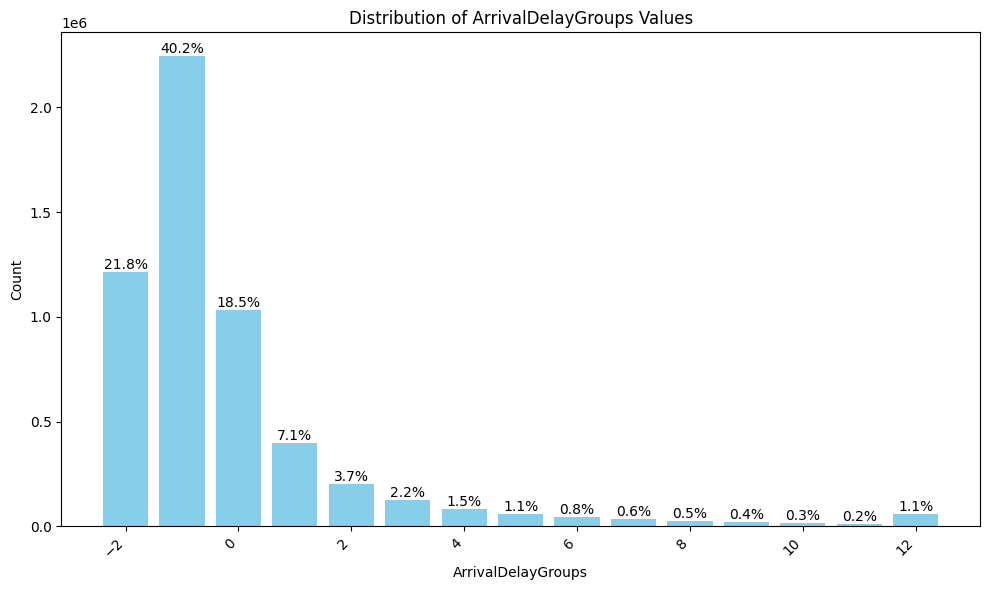

In [ ]:
import matplotlib.pyplot as plt


# Convert the PySpark DataFrame to a Pandas DataFrame for plotting
pd_value_counts = value_counts.toPandas()

# Calculate percentage
pd_value_counts['percentage'] = (pd_value_counts['count'] / pd_value_counts['count'].sum()) * 100

# Plot a bar chart with percentage on top of each bar
plt.figure(figsize=(10, 6))
bars = plt.bar(pd_value_counts['ArrivalDelayGroups'], pd_value_counts['count'], color='skyblue')

# Add percentage on top of each bar
for bar, percentage in zip(bars, pd_value_counts['percentage']):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.05,
             f'{percentage:.1f}%', ha='center', va='bottom')

plt.xlabel('ArrivalDelayGroups')
plt.ylabel('Count')
plt.title('Distribution of ArrivalDelayGroups Values')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


Merging ArrivalDelayGroups

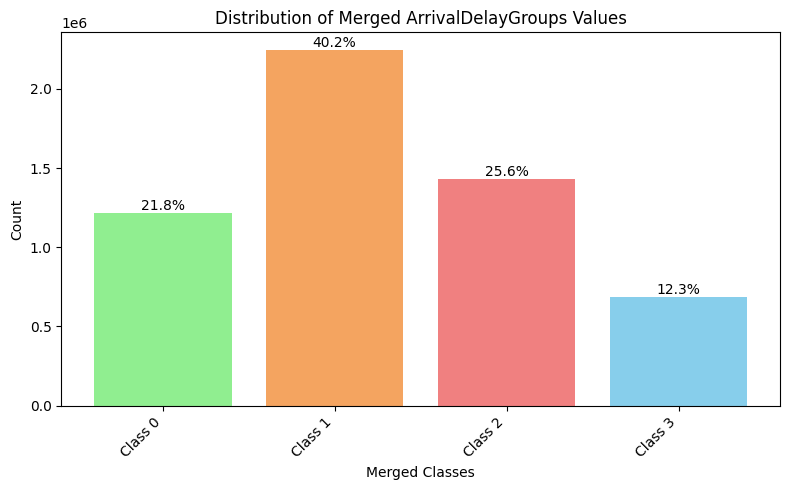

In [ ]:
import matplotlib.pyplot as plt
from pyspark.sql.functions import when, col

conditions = [
    (col('ArrivalDelayGroups').isin(-2.0)),
    (col('ArrivalDelayGroups').isin(-1.0)),
    (col('ArrivalDelayGroups').isin(0.0, 1.0)),
    (col('ArrivalDelayGroups').isin(2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0))
]
# Create a new column 'ArrivalDelayGroups_merged' based on conditions
df = df.withColumn('ArrivalDelayGroups_merged',
                   when(conditions[0], 0)
                   .when(conditions[1], 1)
                   .when(conditions[2], 2)
                   .when(conditions[3], 3))

value_counts = df.groupBy('ArrivalDelayGroups_merged').count()
pd_value_counts = value_counts.toPandas()


# Calculate percentage
pd_value_counts['percentage'] = (pd_value_counts['count'] / pd_value_counts['count'].sum()) * 100

colors = ['sandybrown','skyblue', 'lightcoral', 'lightgreen'] #, 'yellow']

# Plot a bar chart with percentage on top of each bar
plt.figure(figsize=(8, 5))
bars = plt.bar(pd_value_counts['ArrivalDelayGroups_merged'], pd_value_counts['count'], color=colors)

# Add percentage on top of each bar
for bar, percentage in zip(bars, pd_value_counts['percentage']):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.05,
             f'{percentage:.1f}%', ha='center', va='bottom')

plt.xticks([0, 1, 2, 3], ['Class 0', 'Class 1', 'Class 2', 'Class 3'], rotation=45, ha='right')

plt.xlabel('Merged Classes')
plt.ylabel('Count')
plt.title('Distribution of Merged ArrivalDelayGroups Values')
plt.tight_layout()
plt.show()


### LabelEncoding for city airline and state

In [ ]:
from pyspark.ml.feature import StringIndexer
columns_to_encode = ['Airline', 'OriginStateName', 'OriginCityName']

# Perform label encoding on multiple columns
indexer_models = {}
df_encoded = df

for column in columns_to_encode:
    indexer = StringIndexer(inputCol=column, outputCol=f"{column}Index")
    indexer_model = indexer.fit(df_encoded)
    df_encoded = indexer_model.transform(df_encoded)
    indexer_models[column] = indexer_model


# Get the mappings between original values and label-encoded values for each column
column_mappings = {}

for column, indexer_model in indexer_models.items():
    column_mappings[column] = dict(zip(indexer_model.labels, range(len(indexer_model.labels))))
    print(f"{column} Mapping:")
    print(column_mappings[column])



df_encoded.show()



+-------------------+--------------------+------+----+---------+--------+--------+-------+--------+-----+----------+---------+-------------------------+---------------------------------------+-------------------------------+-----------------+-----------+-------------------------------+---------------+--------------------+---------------+-------------+-------------------+-------------+--------+--------------------+----------+--------+--------+------------------+----------+-------------+------------------+-------+-------+---------+--------+-------------------+------------------+--------------------+-------------------+------------------------+------------------------+--------------------------+-------------------------+-------------------------+------------+--------------------+-------------------+
|         FlightDate|             Airline|Origin|Dest|Cancelled|Diverted|DepDelay|AirTime|Distance|Month|DayofMonth|DayOfWeek|Marketing_Airline_Network|Operated_or_Branded_Code_Share_Partners|

In [ ]:

# Get the data types of each column
column_data_types = df_encoded.dtypes

# Separate columns into numerical and categorical
numerical_columns = []
categorical_columns = []

for col_name, data_type in column_data_types:
    if 'int' in data_type or 'double' in data_type:
        numerical_columns.append(col_name)
    else:
        categorical_columns.append(col_name)

# Print the result
print("Numerical Columns:")
print(numerical_columns)

print("\nCategorical Columns:")
print(categorical_columns)

Numerical Columns:
['DepDelay', 'AirTime', 'Distance', 'Month', 'DayofMonth', 'DayOfWeek', 'Flight_Number_Marketing_Airline', 'Flight_Number_Operating_Airline', 'OriginAirportID', 'DestAirportID', 'DepDel15', 'DepartureDelayGroups', 'ArrDelay', 'ArrDel15', 'ArrivalDelayGroups', 'DistanceGroup', 'DivAirportLandings', 'DepTime', 'ArrTime', 'WheelsOff', 'WheelsOn', 'scaled_DepDelay', 'scaled_AirTime', 'scaled_Distance', 'scaled_ArrDelay', 'scaled_DepTime_InMinutes', 'scaled_ArrTime_InMinutes', 'scaled_WheelsOff_InMinutes', 'scaled_WheelsOn_InMinutes', 'ArrivalDelayGroups_merged', 'AirlineIndex', 'OriginStateNameIndex', 'OriginCityNameIndex']

Categorical Columns:
['FlightDate', 'Airline', 'Origin', 'Dest', 'Cancelled', 'Diverted', 'Marketing_Airline_Network', 'Operated_or_Branded_Code_Share_Partners', 'Operating_Airline', 'Tail_Number', 'OriginCityName', 'OriginStateName', 'DestCityName', 'DestStateName', 'DepTimeBlk', 'ArrTimeBlk']


Keeping only numerical columns

In [ ]:
column_data_types_encoded = df_encoded.dtypes

# Select only numerical columns
numerical_columns_encoded = [col_name for col_name, data_type in column_data_types_encoded if 'int' in data_type or 'double' in data_type]


df_numerical = df_encoded.select(*(numerical_columns_encoded))

# Dropping columns that we now that are effectively the same we want to predict or could be higly correlated
columns_to_drop = ['DepDel15','ArrDel15', 'AirTIme', 'Distance', 'scaled_ArrDelay',
                    'scaled_DepDelay','WheelsOn', 'WheelsOff',
                   'scaled_DepTime_InMinutes', 'scaled_ArrTime_InMinutes', 'CRSDepTime', 'CRSArrTime',
                   'DepTime', 'ArrTime', 'ArrDelay', 'DivAirportLandings', 'DepDelay']

df_numerical = df_numerical.drop(*columns_to_drop)

df_numerical.show()


+-----+----------+---------+-------------------------------+-------------------------------+---------------+-------------+--------------------+------------------+-------------+------------------+--------------------+--------------------------+-------------------------+-------------------------+------------+--------------------+-------------------+
|Month|DayofMonth|DayOfWeek|Flight_Number_Marketing_Airline|Flight_Number_Operating_Airline|OriginAirportID|DestAirportID|DepartureDelayGroups|ArrivalDelayGroups|DistanceGroup|    scaled_AirTime|     scaled_Distance|scaled_WheelsOff_InMinutes|scaled_WheelsOn_InMinutes|ArrivalDelayGroups_merged|AirlineIndex|OriginStateNameIndex|OriginCityNameIndex|
+-----+----------+---------+-------------------------------+-------------------------------+---------------+-------------+--------------------+------------------+-------------+------------------+--------------------+--------------------------+-------------------------+-------------------------+-----

Correlation matrix


Correlation Matrix
- dropping one correlated item of the pair if there is more than 85 %
correlation

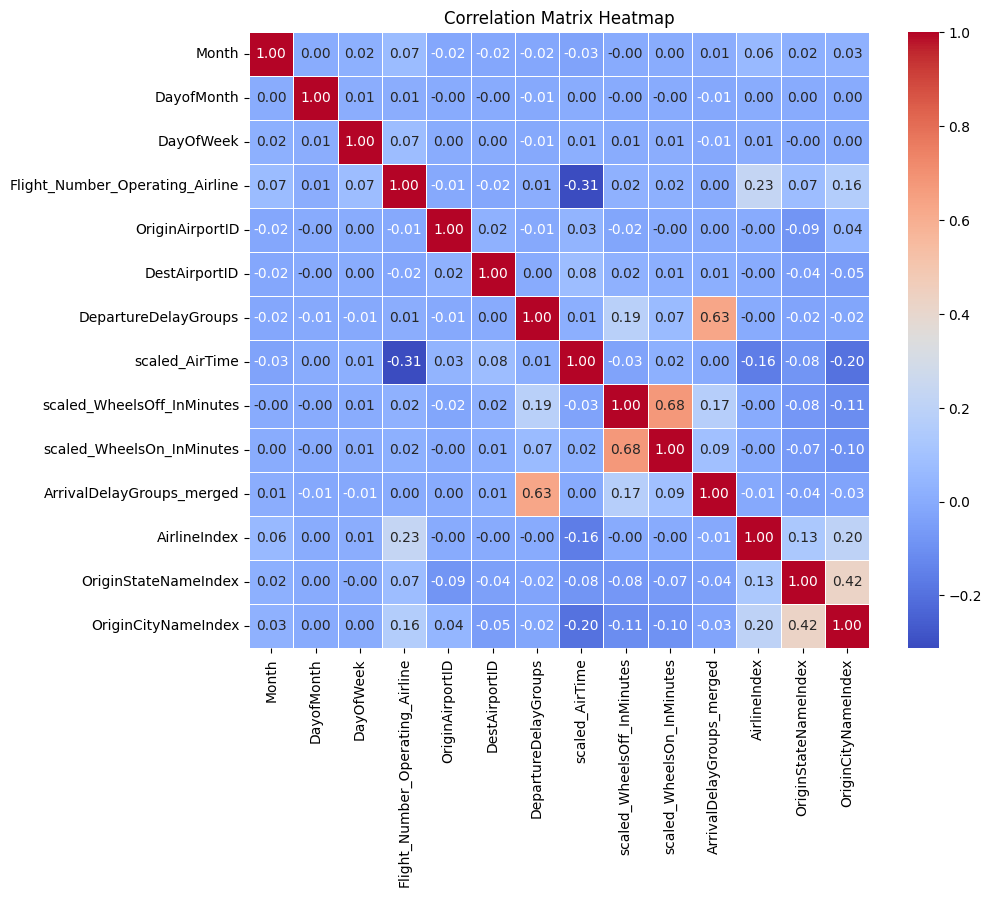

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler
from pyspark.sql import SparkSession
import pandas as pd


# Select numerical columns for correlation analysis
numerical_columns = [col for col in df_numerical.columns]
vec_assembler_corr = VectorAssembler(inputCols=numerical_columns, outputCol='features')

# Transform the DataFrame
df_numerical_corr = vec_assembler_corr.transform(df_numerical).select('features')

# Compute the correlation matrix
correlation_matrix = Correlation.corr(df_numerical_corr, 'features').head()
corr_matrix = correlation_matrix[0].toArray()
corr_df = pd.DataFrame(corr_matrix, columns=numerical_columns, index=numerical_columns)

# heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_df, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.title('Correlation Matrix Heatmap')
plt.show()


In [ ]:
df_numerical = df_numerical.drop('ArrivalDelayGroups', 'DistanceGroup', 'Flight_Number_Marketing_Airline','scaled_Distance') # Drop effective columns and higly correlated

In [ ]:
df_numerical.printSchema()

root
 |-- Month: long (nullable = true)
 |-- DayofMonth: long (nullable = true)
 |-- DayOfWeek: long (nullable = true)
 |-- Flight_Number_Operating_Airline: long (nullable = true)
 |-- OriginAirportID: long (nullable = true)
 |-- DestAirportID: long (nullable = true)
 |-- DepartureDelayGroups: double (nullable = true)
 |-- scaled_AirTime: double (nullable = true)
 |-- scaled_WheelsOff_InMinutes: double (nullable = true)
 |-- scaled_WheelsOn_InMinutes: double (nullable = true)
 |-- ArrivalDelayGroups_merged: integer (nullable = true)
 |-- AirlineIndex: double (nullable = false)
 |-- OriginStateNameIndex: double (nullable = false)
 |-- OriginCityNameIndex: double (nullable = false)



Random Forest
- Loop for various parameters because of the bad functioning of grid search


In [ ]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd

label_column = 'ArrivalDelayGroups_merged'

feature_columns = [col for col in df_numerical.columns if col != label_column]

vec_assembler = VectorAssembler(inputCols=feature_columns, outputCol='features')

(training_data, testing_data) = df_numerical.randomSplit([0.7, 0.3], seed=42)

# Initialize variables to store the best model and its accuracy
best_accuracy = 0.0
best_max_depth = 0
best_num_trees = 0

# Define the ranges for maxDepth and numTrees
max_depth_values = [5, 10, 15]
num_trees_values = [5, 10, 15]

for max_depth in max_depth_values:
    for num_trees in num_trees_values:
        random_forest = RandomForestClassifier(
            featuresCol='features',
            labelCol=label_column,
            numTrees=num_trees,
            maxBins=400,
            maxDepth=max_depth,
            seed = 0
        )

        pipeline = Pipeline(stages=[vec_assembler, random_forest])
        rf_model = pipeline.fit(training_data)
        predictions = rf_model.transform(testing_data)

        evaluator_accuracy = MulticlassClassificationEvaluator(labelCol=label_column, metricName='accuracy')
        accuracy = evaluator_accuracy.evaluate(predictions)

        # Print the current combination's accuracy
        print(f"maxDepth={max_depth}, numTrees={num_trees}, Accuracy: {accuracy}")

        # Update the best model if the current one is better
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_max_depth = max_depth
            best_num_trees = num_trees

# Print the best model's parameters and accuracy
print("\nBest Model Parameters:")
print(f"MaxDepth: {best_max_depth}")
print(f"NumTrees: {best_num_trees}")
print(f"Best Model Accuracy: {best_accuracy}")


maxDepth=5, numTrees=5, Accuracy: 0.5516118201338016
maxDepth=5, numTrees=10, Accuracy: 0.5544842880545243
maxDepth=5, numTrees=15, Accuracy: 0.5514875536347353
maxDepth=10, numTrees=5, Accuracy: 0.5747498837988747


ERROR:root:KeyboardInterrupt while sending command.
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "/usr/local/lib/python3.10/dist-packages/py4j/clientserver.py", line 511, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
  File "/usr/lib/python3.10/socket.py", line 705, in readinto
    return self._sock.recv_into(b)
KeyboardInterrupt


KeyboardInterrupt: ignored

In [ ]:

label_column = 'ArrivalDelayGroups_merged'

# Select feature columns without the target variable
feature_columns = [col for col in df_numerical.columns if col != label_column]


vec_assembler = VectorAssembler(inputCols=feature_columns, outputCol='features')
random_forest = RandomForestClassifier(featuresCol='features', labelCol=label_column, numTrees=15, maxBins = 400, maxDepth = 10, seed = 0)

pipeline = Pipeline(stages=[vec_assembler, random_forest])



(training_data, testing_data) = df_numerical.randomSplit([0.7, 0.3], seed=42)

# Train the model
rf_model = pipeline.fit(training_data)

# y_pred predictions
predictions = rf_model.transform(testing_data)

# Evaluate the model
evaluator_accuracy = MulticlassClassificationEvaluator(labelCol=label_column, metricName='accuracy')
accuracy = evaluator_accuracy.evaluate(predictions)
print(f"Accuracy: {accuracy}")


predictions_pd = predictions.select(['prediction', label_column]).toPandas()
conf_matrix = confusion_matrix(predictions_pd[label_column], predictions_pd['prediction'])
print("Confusion Matrix:")
print(conf_matrix)
report = classification_report(predictions_pd[label_column], predictions_pd['prediction'])
print("Classification Report:")
print(report)



Accuracy: 0.575669933840038
Confusion Matrix:
[[ 43520 307733  12916     21]
 [ 22645 576661  73656    278]
 [ 10010 218427 177282  24033]
 [  1011  11794  27729 166106]]
Classification Report:
              precision    recall  f1-score   support

           0       0.56      0.12      0.20    364190
           1       0.52      0.86      0.65    673240
           2       0.61      0.41      0.49    429752
           3       0.87      0.80      0.84    206640

    accuracy                           0.58   1673822
   macro avg       0.64      0.55      0.54   1673822
weighted avg       0.59      0.58      0.53   1673822



Feature importance plot


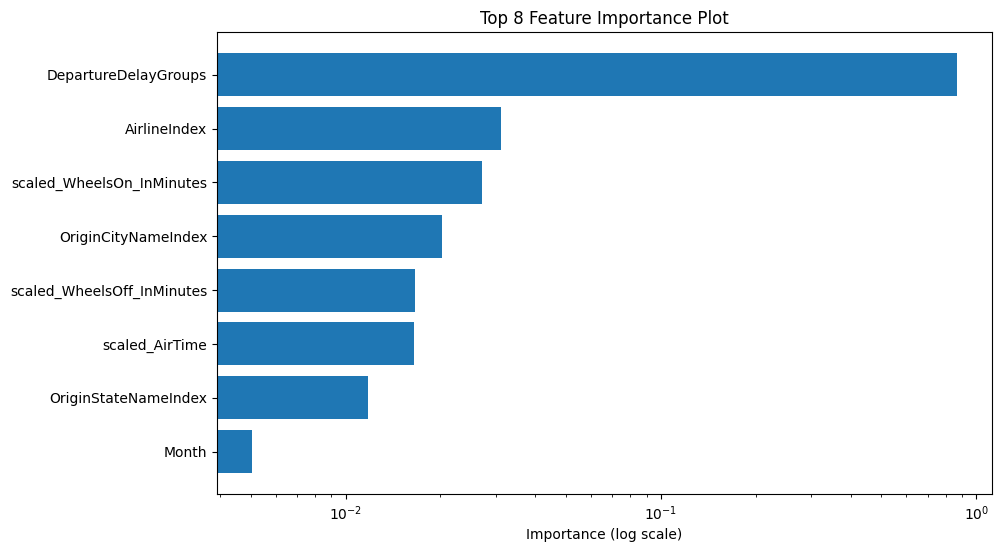

In [ ]:

feature_importances = rf_model.stages[-1].featureImportances.toArray()

# Pandas DataFrame for easier plotting
feature_importance_df = pd.DataFrame({'Feature': feature_columns, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=True)

top_features = feature_importance_df.tail(8)

plt.figure(figsize=(10, 6))
plt.barh(top_features['Feature'], top_features['Importance'])
plt.xscale('log')  # logarithmic scale for better visualization of smaller values
plt.xlabel('Importance (log scale)')
plt.title('Top 8 Feature Importance Plot')
plt.show()



Confusion Matrix:
[[ 43520 307733  12916     21]
 [ 22645 576661  73656    278]
 [ 10010 218427 177282  24033]
 [  1011  11794  27729 166106]]
Classification Report:
              precision    recall  f1-score   support

           0       0.56      0.12      0.20    364190
           1       0.52      0.86      0.65    673240
           2       0.61      0.41      0.49    429752
           3       0.87      0.80      0.84    206640

    accuracy                           0.58   1673822
   macro avg       0.64      0.55      0.54   1673822
weighted avg       0.59      0.58      0.53   1673822



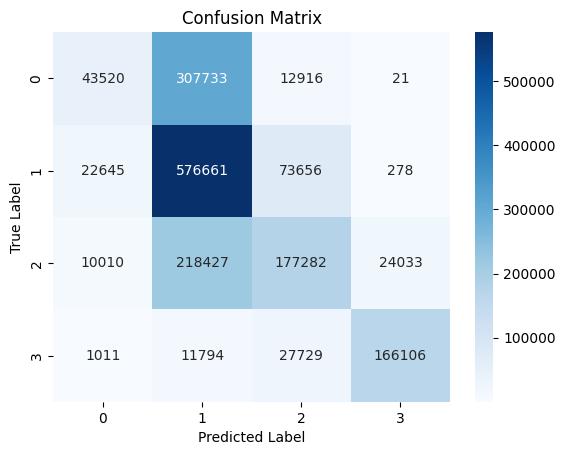

In [ ]:
#Calculate predictions and put it to pandas

predictions_pd = predictions.select(['prediction', label_column]).toPandas()
conf_matrix = confusion_matrix(predictions_pd[label_column], predictions_pd['prediction'])

print("Confusion Matrix:")
print(conf_matrix)

report = classification_report(predictions_pd[label_column], predictions_pd['prediction'])

print("Classification Report:")
print(report)

sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


### Logistics Regression

In [ ]:


label_column = 'ArrivalDelayGroups_merged'

# Select feature columns
feature_columns = [col for col in df_numerical.columns if col != label_column]

vec_assembler = VectorAssembler(inputCols=feature_columns, outputCol='features')

logistic_regression = LogisticRegression(
    featuresCol='features',
    labelCol=label_column,
    maxIter=10,  # Set the maximum number of iterations
    regParam=0.1,  # Regularization parameter
    family="multinomial"
)

pipeline = Pipeline(stages=[vec_assembler, logistic_regression])

# training and testing sets
(training_data, testing_data) = df_numerical.randomSplit([0.7, 0.3], seed=42)

# Train the model
logistic_regression_model = pipeline.fit(training_data)

# y_pred predictions
predictions = logistic_regression_model.transform(testing_data)


evaluator_accuracy = MulticlassClassificationEvaluator(labelCol=label_column, metricName='accuracy')
accuracy = evaluator_accuracy.evaluate(predictions)




print(f"Accuracy: {accuracy}")

# Confusion matrix
predictions_pd = predictions.select(['prediction', label_column]).toPandas()
conf_matrix = confusion_matrix(predictions_pd[label_column], predictions_pd['prediction'])

print("Confusion Matrix:")
print(conf_matrix)

# Classification report
report = classification_report(predictions_pd[label_column], predictions_pd['prediction'])

print("Classification Report:")
print(report)


Accuracy: 0.503261995600488
Confusion Matrix:
[[  2789 358347   3053      1]
 [  2635 662194   8389     22]
 [  2674 375409  49459   2210]
 [   319  35164  43228 127929]]
Classification Report:
              precision    recall  f1-score   support

           0       0.33      0.01      0.01    364190
           1       0.46      0.98      0.63    673240
           2       0.47      0.12      0.19    429752
           3       0.98      0.62      0.76    206640

    accuracy                           0.50   1673822
   macro avg       0.56      0.43      0.40   1673822
weighted avg       0.50      0.50      0.40   1673822



Support Vector Machine

In [ ]:
label_column = 'ArrivalDelayGroups_merged'

feature_columns = [col for col in df_numerical.columns if col != label_column]
vec_assembler = VectorAssembler(inputCols=feature_columns, outputCol='features')
svm_classifier = LinearSVC(featuresCol='features', labelCol=label_column, maxIter=20, regParam=0.1)
ovr_classifier = OneVsRest(classifier=svm_classifier, labelCol=label_column)
pipeline = Pipeline(stages=[vec_assembler, ovr_classifier])

# Split the data into training and testing sets
(training_data, testing_data) = df_numerical.randomSplit([0.7, 0.3], seed=42)

# Train the model
svm_model = pipeline.fit(training_data)

# Make predictions on the testing set
predictions = svm_model.transform(testing_data)

# Evaluate the model
evaluator_accuracy = MulticlassClassificationEvaluator(labelCol=label_column, metricName='accuracy')
accuracy = evaluator_accuracy.evaluate(predictions)

# Display the accuracy
print(f"Accuracy: {accuracy}")

# predictions to Pandas DataFrame
predictions_pd = predictions.select(['prediction', label_column]).toPandas()


conf_matrix = confusion_matrix(predictions_pd[label_column], predictions_pd['prediction'])

# Display the confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

report = classification_report(predictions_pd[label_column], predictions_pd['prediction'])

# Display the classification report
print("Classification Report:")
print(report)


Accuracy: 0.5108428494786184
Confusion Matrix:
[[ 18097 332443  12473   1332]
 [ 11817 622276  27032  12544]
 [  4592 274436  26414 123796]
 [   297  15711   2289 188273]]
Classification Report:
              precision    recall  f1-score   support

           0       0.52      0.05      0.09    364345
           1       0.50      0.92      0.65    673669
           2       0.39      0.06      0.11    429238
           3       0.58      0.91      0.71    206570

    accuracy                           0.51   1673822
   macro avg       0.50      0.49      0.39   1673822
weighted avg       0.48      0.51      0.40   1673822



Gradient Boosting Classifier

Accuracy: 0.5674068090872267
Confusion Matrix:
[[ 60618 290006  13716      5]
 [ 41060 580727  51814     68]
 [ 19048 243561 148305  18324]
 [  1825  12815  31842 160088]]
Classification Report:
              precision    recall  f1-score   support

           0       0.49      0.17      0.25    364345
           1       0.52      0.86      0.64    673669
           2       0.60      0.35      0.44    429238
           3       0.90      0.77      0.83    206570

    accuracy                           0.57   1673822
   macro avg       0.63      0.54      0.54   1673822
weighted avg       0.58      0.57      0.53   1673822



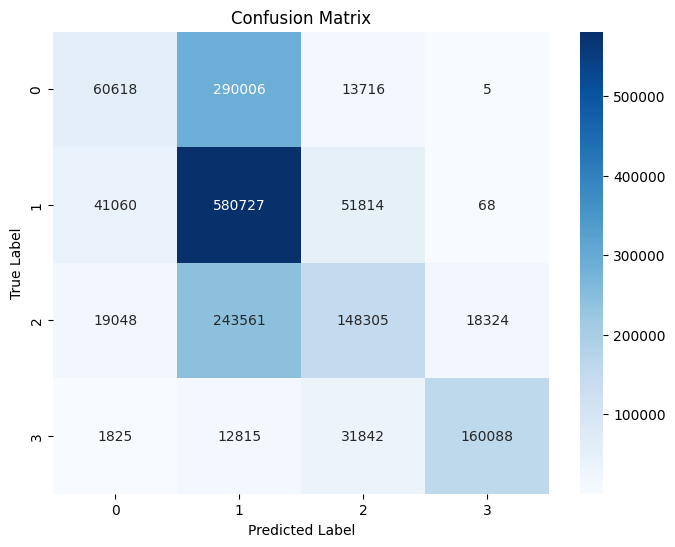

In [ ]:

label_column = 'ArrivalDelayGroups_merged'



feature_columns = [col for col in df_numerical.columns if col != label_column]

# Create a VectorAssembler
vec_assembler = VectorAssembler(inputCols=feature_columns, outputCol='features')

gbt_classifier = GBTClassifier(featuresCol='features', labelCol=label_column, maxDepth=3, maxIter=10, seed=42, maxBins = 400 )

ovr_classifier = OneVsRest(classifier=gbt_classifier, labelCol=label_column)

pipeline = Pipeline(stages=[vec_assembler, ovr_classifier])

(training_data, testing_data) = df_numerical.randomSplit([0.7, 0.3], seed=42)

# Train the model
gbt_model = pipeline.fit(training_data)

predictions = gbt_model.transform(testing_data)

# Evaluate
evaluator_accuracy = MulticlassClassificationEvaluator(labelCol=label_column, metricName='accuracy')

accuracy = evaluator_accuracy.evaluate(predictions)

print(f"Accuracy: {accuracy}")

# Convert predictions to Pandas DataFrame
predictions_pd = predictions.select(['prediction', label_column]).toPandas()

conf_matrix = confusion_matrix(predictions_pd[label_column], predictions_pd['prediction'])

print("Confusion Matrix:")
print(conf_matrix)

report = classification_report(predictions_pd[label_column], predictions_pd['prediction'])

print("Classification Report:")
print(report)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


MultiLayer Perceptron

In [ ]:
len(feature_columns)

Accuracy: 0.40201843311917024
Confusion Matrix:
[[     0 364890      0      0]
 [     0 673087      0      0]
 [     0 429330      0      0]
 [     0 206962      0      0]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00    364890
           1       0.40      1.00      0.57    673087
           2       0.00      0.00      0.00    429330
           3       0.00      0.00      0.00    206962

    accuracy                           0.40   1674269
   macro avg       0.10      0.25      0.14   1674269
weighted avg       0.16      0.40      0.23   1674269



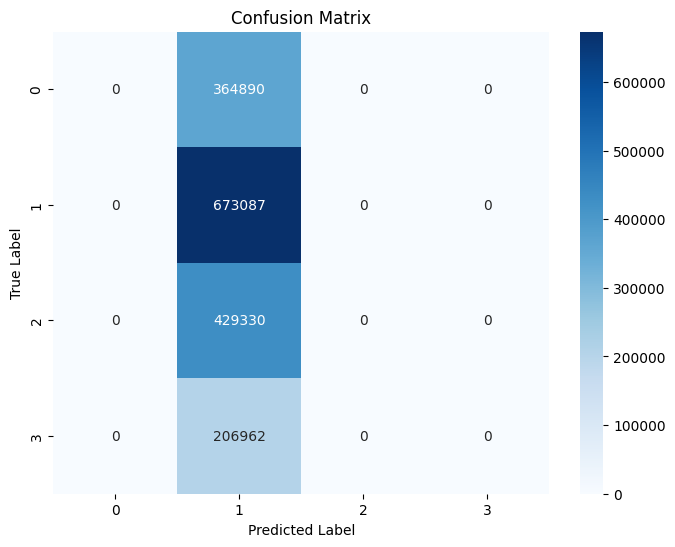

In [ ]:

label_column = 'ArrivalDelayGroups_merged'

feature_columns = [col for col in df_numerical.columns if col != label_column]



assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

mlp_classifier = MultilayerPerceptronClassifier(
    labelCol=label_column,
    featuresCol="features",
    layers=[len(feature_columns), 10, 5, 4],  # the layers for four classes
    blockSize=128,
    seed=1244
)

pipeline = Pipeline(stages=[assembler, mlp_classifier])

(train_data, test_data) = df_numerical.randomSplit([0.7, 0.3], seed=1234)

model = pipeline.fit(train_data)




predictions = model.transform(test_data)

# Evaluate the model
evaluator = MulticlassClassificationEvaluator(
    labelCol=label_column,
    predictionCol="prediction",
    metricName="accuracy"
)

accuracy = evaluator.evaluate(predictions)
print(f"Accuracy: {accuracy}")


# Convert predictions to Pandas DataFrame
predictions_pd = predictions.select(['prediction', label_column]).toPandas()

conf_matrix = confusion_matrix(predictions_pd[label_column], predictions_pd['prediction'])

print("Confusion Matrix:")
print(conf_matrix)

report = classification_report(predictions_pd[label_column], predictions_pd['prediction'])

print("Classification Report:")
print(report)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()